In [295]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio
import math
import sys
from matplotlib.patches import Polygon
import matplotlib.cm as cm  # Importar módulo de colormap
from Quad4 import Quad4
from Node import Node
from units import mm, cm, m, kgf, N, tf, kN, MPa, GPa
from fem import Material, Membrane
from functions import matrix_extract,  get_nodes_from_physical_id, get_line_load_global_vector, matrix_replace

In [ ]:
output_file = "mallas/malla_quad9L4.msh"   #cambiar el numero de la malla --> malla_quad4G1.msh, malla_quad4G2.msh, malla_quad4G3.msh, malla_quad4G4.msh, malla_quad4L1.msh,....
titulo = "Optimización de perfil" #Cambiar el numero y G-->L

Then, we create all the material properties

In [297]:
ASTM_36 = Material.Material(name="ASTM 36", E=200.0 * GPa, nu=0.30, rho=7850 * kgf / m**3)
Sup1 = Membrane.Membrane(name="Steel", thickness=2 * cm, material=ASTM_36)
Sup2 = Membrane.Membrane(name="Steel", thickness=2 * cm, material=ASTM_36)
section_dict = {"201": Sup1, "202":Sup2}

Now is necessary to group the nodes in differnt groups. In this case, there are 3 groups: Heads, handle_big and handle_thin

In [298]:
def crear_nodo(node_id, coords, grupo):
    restrain = ["r", "r"] if grupo in ["BC_R1", "BC_R2"] else ["f", "f"]
    return Node(node_id, coords, restrain=restrain)

mesh = meshio.read(output_file)
tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}

grupos = {}
    # Elementos tipo "quad" → para el dominio estructural
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
        if cell_block.type != "quad":
            continue
        for quad, tag in zip(cell_block.data, phys_tags):
            nombre = tag_to_name.get(tag, f"{tag}")
            if nombre not in grupos:
                grupos[nombre] = []
            for node_id in quad:
                x, y = mesh.points[node_id][:2]
                grupos[nombre].append(Node(node_id + 1, [x, y]))

    # Elementos tipo "line" → condiciones de borde
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
        if cell_block.type != "line":
            continue
        for line, tag in zip(cell_block.data, phys_tags):
            nombre = tag_to_name.get(tag, f"{tag}")
            if nombre not in grupos:
                grupos[nombre] = []
            for node_id in line:
                x, y = mesh.points[node_id][:2]
                restrain = ["f", "f"]
                if nombre in ["BC_R1"]:
                    restrain = ["r", "r"]
                grupos[nombre].append(Node(node_id + 1, [x, y], restrain=restrain))

    # Eliminar nodos duplicados por grupo (según id)
for nombre in grupos:
        nodos_unicos = {}
        for nodo in grupos[nombre]:
            nodos_unicos[nodo.name] = nodo
        grupos[nombre] = list(nodos_unicos.values())

In [299]:
nodes_dict = {}
for group in grupos:
    for node in grupos[group]:
        nodes_dict[node.name] = node

In [300]:
def ordenar_nodos_quad(nodos):
    coords = np.array([n.coordenadas for n in nodos])
    cx, cy = np.mean(coords, axis=0)
    angulos = np.arctan2(coords[:, 1] - cy, coords[:, 0] - cx)
    orden = np.argsort(angulos)
    return [nodos[i] for i in orden]

In [301]:
quads = mesh.cells_dict.get('quad', [])
tags = mesh.cell_data_dict["gmsh:physical"].get("quad", [])
elements = []
nodes = set()
nodos_faltantes = []

for i in range(len(tags)):
        section_tag = str(tags[i])
        if section_tag not in section_dict:
            print(f"⚠️ Tag físico {section_tag} no tiene sección asociada. Elemento {i+1} omitido.")
            continue

        section = section_dict[section_tag]
        node_ids = quads[i]

        try:
            nodos = [nodes_dict[node_id + 1] for node_id in node_ids]
        except KeyError as e:
            nodos_faltantes.append(node_ids)
            print(f"❌ Nodo no encontrado en nodes_dict: {e}")
            continue

        for nodo in nodos:
            
            nodes.add(nodo)
        nodos = ordenar_nodos_quad(nodos)
        #print(nodos)

        element = Quad4(i + 1, nodos, section)
        elements.append(element)

if nodos_faltantes:
        print(f"❌ Se omitieron {len(nodos_faltantes)} elementos por nodos faltantes.")

Here we plot the element, and see if the nodes that are restrain (Nut) or have a force applied (Force) are identified and plotted

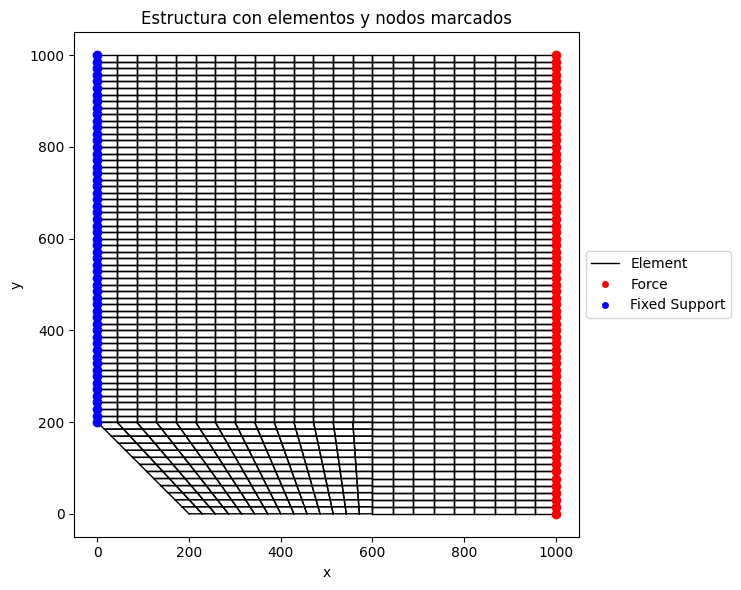

In [302]:
todos_los_nodos =  list(set(nodes) | set(grupos.get("BC_R1", [])) | set(grupos.get("BC_1", [])) | set(grupos.get("otros_grupos", [])))

x = np.array([node.coordenadas[0] for node in todos_los_nodos])
y = np.array([node.coordenadas[1] for node in todos_los_nodos])
node_index_map = {node.name: i for i, node in enumerate(todos_los_nodos)}

fig, ax = plt.subplots(figsize=(8, 6))

# Dibujar elementos
for elem in elements:
    indices = [node_index_map[node.name] for node in elem.node_list]
    coords = np.array([[x[i], y[i]] for i in indices + [indices[0]]])
    ax.plot(coords[:, 0], coords[:, 1], "k-", linewidth=1)

# Dibujar nodos Force
# Dibujar grupo BC_1 en verde si existe
if "BC_1" in grupos:
    for i, node in enumerate(grupos["BC_1"]):
        if node.name in node_index_map:
            idx = node_index_map[node.name]
            ax.plot(x[idx], y[idx], "ro", markersize=6, label="BC_1" if i == 0 else "")

# Dibujar nodos Nut
# Dibujar apoyos en azul desde los grupos físicos "BC_R1" y "BC_R2"
for grupo in ["BC_R1"]:
    if grupo in grupos:
        for i, node in enumerate(grupos[grupo]):
            if node.name in node_index_map:
                idx = node_index_map[node.name]
                ax.plot(x[idx], y[idx], 'bo', markersize=6, label='Restricción' if i == 0 else '')
                
# Finalizar gráfico
ax.set_title("Estructura con elementos y nodos marcados")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")
ax.legend(
    handles=[
        plt.Line2D([0], [0], color="k", lw=1, label="Element"),
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="r", markersize=6, label="Force"),
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="b", markersize=6, label="Fixed Support"),
    ],
    loc="center left",
    bbox_to_anchor=(1.0, 0.5)
)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [303]:
def solve(nodes, elements):
    """
    Resuelve el sistema FEM considerando cargas distribuidas en líneas.

    Args:
        nodes (list): Lista de nodos con .idx, .nodalLoad, .restrain
        elements (list): Lista de elementos con .kg, .idx
        mesh: Objeto meshio con malla y etiquetas físicas
        load_dictionary (dict): Dict {id_físico: valor_carga}

    Returns:
        u (np.ndarray): Desplazamientos globales
        F_reactions (np.ndarray): Reacciones en DOFs restringidos
        Fj (np.ndarray): Fuerzas nodales aplicadas
        F_total (np.ndarray): Fuerzas totales incluyendo reacciones
    """
    nNodes = len(nodes)
    system_nDof = 2 * nNodes  # 2 DOFs por nodo

    # === CARGAS DISTRIBUIDAS EN LÍNEAS ===
    F_line_global = np.zeros(system_nDof)
    Fj = np.zeros(system_nDof)
    for node in nodes:
        for dof_idx, force in zip(node.idx, node.nodalLoad):
            Fj[dof_idx] = force
  
    # === MATRIZ DE RIGIDEZ GLOBAL ===
    Kg = np.zeros((system_nDof, system_nDof))
    for element in elements:
        Kg = matrix_replace(Kg, element.kg, element.idx, element.idx)


    # === RESTRICCIONES ===
    nodeIndex = np.full(system_nDof, '', dtype=str)
    for node in nodes:
        for dof_idx, status in zip(node.idx, node.restrain):
            nodeIndex[dof_idx] = status

    freeIndices = np.where(nodeIndex == 'f')[0]
    restrainedIndices = np.where(nodeIndex == 'r')[0]
 
    # === PARTICIÓN DEL SISTEMA ===
    Kff = matrix_extract(Kg, freeIndices, freeIndices)
    Kfr = matrix_extract(Kg, freeIndices, restrainedIndices)
    Krf = matrix_extract(Kg, restrainedIndices, freeIndices)
    Krr = matrix_extract(Kg, restrainedIndices, restrainedIndices)

    # === FUERZA TOTAL (aplicada + distribuida) ===
    F = Fj + F_line_global
    Ff = F[freeIndices]
    Fr = F[restrainedIndices]

    # === SOLUCIÓN ===
    uf = np.linalg.solve(Kff, Ff - Kfr @ Fr)
    ur = np.zeros(len(restrainedIndices))

    u = np.zeros(system_nDof)
    u[freeIndices] = uf
    u[restrainedIndices] = ur
    
    # === REACCIONES ===
    Fr = Krf @ uf + Krr @ ur
    F_reactions = np.zeros(system_nDof)
    F_reactions[restrainedIndices] = Fr
    
    return u

In [304]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

De aquí para abajo empieza la configuración de las fuerzas:

1er caso: Fuerza distribuida

2do caso: Fuerza puntual

3er caso: Fuerza distribuida con peso propio

Primer Caso: Fuerza distribuida

In [305]:
def apply_distributed_force(grupo_nodos, fuerza_total):
    """
    Aplica una fuerza distribuida a lo largo de una línea definida por nodos.
    La fuerza total se reparte proporcionalmente según la longitud de cada segmento.

    Args:
        grupo_nodos (list): Lista de nodos (Node) ordenados a lo largo de la línea.
        fuerza_total (float): Fuerza total a repartir (en N o unidades consistentes).
                              Puede estar en cualquier dirección (por ejemplo, solo vertical).
    """
    nodos = grupo_nodos
    n = len(nodos)

    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Paso 1: calcular longitud total y longitudes de tramos
    longitudes = []
    total_length = 0.0

    for i in range(n - 1):
        dx = nodos[i+1].coordenadas[0] - nodos[i].coordenadas[0]
        dy = nodos[i+1].coordenadas[1] - nodos[i].coordenadas[1]
        L = np.sqrt(dx**2 + dy**2)
        longitudes.append(L)
        total_length += L

    if total_length == 0:
        print("La longitud total es cero, no se puede aplicar la fuerza.")
        return

    # Paso 2: calcular fuerza distribuida por unidad de longitud
    q_lineal = fuerza_total / total_length  # N/m

    # Paso 3: inicializar fuerzas nodales acumuladas
    nodal_forces = {node.name: np.array([0.0, 0.0]) for node in nodos}

    # Paso 4: recorrer cada segmento y distribuir fuerza
    for i in range(n - 1):
        ni = nodos[i]
        nj = nodos[i + 1]
        xi, yi = ni.coordenadas
        xj, yj = nj.coordenadas

        dx = xj - xi
        dy = yj - yi
        L = longitudes[i]

        # Vector unitario del tramo
        tx = dx / L
        ty = dy / L

        # Vector normal (perpendicular)
        nx = 1
        ny = 0  # sentido hacia abajo si horizontal

        # Fuerza total en el tramo
        F_total = q_lineal * L

        # Componentes globales de la fuerza
        fx = F_total * nx
        fy = F_total * ny

        # Distribuir mitad a cada nodo del segmento
        nodal_forces[ni.name] += np.array([fx / 2, fy / 2])
        nodal_forces[nj.name] += np.array([fx / 2, fy / 2])

    # Paso 5: asignar fuerzas a cada nodo
    for node in nodos:
        fx, fy = nodal_forces[node.name]
        node.set_nodalLoad([fx, fy])

Acá se define el segundo caso: Fuerza puntual

In [306]:
def single_force(nodes, grupo_nodos, fuerza_total_y):
    """
    Aplica una fuerza puntual vertical (por ejemplo, peso) sobre un nodo específico.
    La fuerza se descompone en x e y.
    """
    for j in nodes:
        j.set_nodalLoad([0,0])
    # Paso 1: ordena nodos si es necesario (aquí asumimos que ya están ordenados)
    nodos = grupo_nodos


    # Paso 2: escoger un nodo específico (por ejemplo, el primero)
    nodo = nodos[0]  # Cambia esto si deseas otro nodo
    x, y = nodo.coordenadas[0], nodo.coordenadas[1]
    # Paso 3: aplicar carga puntual
    # Fuerza total a aplicar
    F_total = fuerza_total_y  # N
    # Componente de fuerza en x y y (globales)
    fx = 0.0  # Cambia esto si deseas una fuerza en x
    fy = F_total  # Fuerza en y
    nodo.set_nodalLoad([0,-fy])


In [307]:
def apply_distributed_force_especial(grupos, elementos, fuerza_total_x):
    """
    Aplica una fuerza distribuida especial sobre los elementos y carga el peso propio.
    """
    # Itera sobre los elementos
    for element in elementos:
        centroid = element.get_centroid()  # Calcula el centroide del elemento

        # Obtener el área del elemento (debería ser calculada dentro de la clase Quad4)
        area = element.area
        thickness = element.section.thickness / 100  # Asegúrate de que el espesor esté en las unidades correctas
        rho = element.section.material.rho  # Densidad del material

        # Calcular el peso del elemento
        weight = area * thickness * rho * 9.81  # Fuerza por el peso propio (en N)

        # Calcular las fuerzas internas distribuidas por el peso
        F_interna = element.body_weight_forces(x=centroid[0], y=centroid[1], force_vector=[0, weight]) / 4  # Distribuir entre 4 nodos

        # Obtener los nodos del elemento
        node_a, node_b, node_c, node_d = element.node_list

        # Actualizar las cargas nodales
        for node, force in zip([node_a, node_b, node_c, node_d], [F_interna] * 4):
            if node.nodalLoad[0] == 0 and node.nodalLoad[1] == 0:
                node.set_nodalLoad([force[0], -force[1]])
            else:
                node.set_nodalLoad([node.nodalLoad[0] + force[0], node.nodalLoad[1] - force[1]])

    # Aplica la fuerza distribuida a los nodos del grupo "Force"
    if "BC_1" in grupos:
        nodos_fuerza = grupos["BC_1"]

    nodos = nodos_fuerza
    n = len(nodos)

    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Calcular longitud total de la línea
    longitudes = []
    total_length = 0
    for i in range(n - 1):
        dx = nodos[i+1].coordenadas[0] - nodos[i].coordenadas[0]
        dy = nodos[i+1].coordenadas[1] - nodos[i].coordenadas[1]
        L = np.sqrt(dx**2 + dy**2)
        longitudes.append(L)
        total_length += L

    # Calcular carga distribuida por unidad de longitud
    q_lineal = fuerza_total_x / total_length  # N/m

    # Aplicar cargas parciales a cada nodo
    nodal_forces = {node.name: np.array([0.0, 0.0]) for node in nodos}

    for i in range(n - 1):
        ni = nodos[i]
        nj = nodos[i + 1]
        xi, yi = ni.coordenadas[0], ni.coordenadas[1]
        xj, yj = nj.coordenadas[0], nj.coordenadas[1]

        dx = xj - xi
        dy = yj - yi
        L = longitudes[i]

        # Dirección normalizada del tramo (unitario)
        vx = dx / L
        vy = dy / L

        # Vector perpendicular (hacia la derecha)
        nx = vy
        ny = vx

        # Fuerza total sobre el tramo
        Fi = q_lineal * L  # Total fuerza sobre el tramo

        # Componentes de fuerza en x y y (globales)
        fx = Fi * nx
        fy = Fi * ny

        # Distribuir mitad a cada nodo
        nodal_forces[ni.name] += np.array([fx / 2, fy / 2])
        nodal_forces[nj.name] += np.array([fx / 2, fy / 2])

    # Asignar fuerzas nodales a los nodos
    for node in nodos:
        fx, fy = nodal_forces[node.name]
        f_px, f_py = node.nodalLoad[0], node.nodalLoad[1]
        node.set_nodalLoad([fx + f_px, fy + f_py])


In [308]:
import numpy as np
import matplotlib.pyplot as plt
import os

def compute_stress_strain_components(elements, u):
    results = []
    for elem in elements:
        sigma, epsilon, _ = elem.get_element_stress(u)  # σxx, σyy, σxy
        exx, eyy, exy = epsilon
        sxx, syy, sxy = sigma

        avg_eps = 0.5 * (exx + eyy)
        rad_eps = np.sqrt(((exx - eyy) / 2) ** 2 + exy ** 2)
        eps1 = avg_eps + rad_eps
        eps2 = avg_eps - rad_eps

        avg_sig = 0.5 * (sxx + syy)
        rad_sig = np.sqrt(((sxx - syy) / 2) ** 2 + sxy ** 2)
        sig1 = avg_sig + rad_sig
        sig2 = avg_sig - rad_sig

        results.append({
            "element": elem.element_tag,
            "σxx": sxx, "σyy": syy, "σxy": sxy,
            "εxx": exx, "εyy": eyy, "εxy": exy,
            "σ1": sig1, "σ2": sig2,
            "ε1": eps1, "ε2": eps2
        })
    return results

def ensure_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

def average_element_values_to_nodes(nodes, elements, element_values):
    from collections import defaultdict
    val_sum = defaultdict(float)
    val_count = defaultdict(int)
    for elem, val in zip(elements, element_values):
        for node in elem.node_list:
            val_sum[node.name] += val
            val_count[node.name] += 1
    node_id_to_avg = {
        nid: val_sum[nid] / val_count[nid] for nid in val_sum
    }
    node_id_to_index = {node.name: i for i, node in enumerate(nodes)}
    nodal_values = np.array([
        node_id_to_avg[node.name] for node in nodes
    ])
    return nodal_values

def quad4_to_triangles(elements, node_id_to_index):
    triangles = []
    for elem in elements:
        ids = [node_id_to_index[n.name] for n in elem.node_list]
        triangles.append([ids[0], ids[1], ids[2]])
        triangles.append([ids[0], ids[2], ids[3]])
    return triangles

def plot_scalar_field_on_mesh(nodes, elements, values, title, folder="figuras", filename=None, cmap="viridis"):
    import matplotlib.tri as mtri
    ensure_dir(folder)
    
    node_id_to_index = {node.name: i for i, node in enumerate(nodes)}
    xs = np.array([node.coordenadas[0] for node in nodes])
    ys = np.array([node.coordenadas[1] for node in nodes])
    nodal_values = np.array(values)
    triangles = quad4_to_triangles(elements, node_id_to_index)
    triang = mtri.Triangulation(xs, ys, triangles)

    # Márgenes automáticos
    x_min, x_max = np.min(xs), np.max(xs)
    y_min, y_max = np.min(ys), np.max(ys)
    x_margin = (x_max - x_min) * 0.05
    y_margin = (y_max - y_min) * 0.05
    x_range = (x_max - x_min) + 2 * x_margin
    y_range = (y_max - y_min) + 2 * y_margin
    fixed_width = 8
    height = fixed_width * (y_range / x_range)

    fig, ax = plt.subplots(figsize=(fixed_width, height))
    tcf = ax.tricontourf(triang, nodal_values, levels=20, cmap=cmap)

    cbar = fig.colorbar(tcf, ax=ax)
    cbar.set_label(title)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    ax.set_aspect("equal", adjustable='box')
    ax.grid(True)
    plt.tight_layout()

    if filename is None:
        filename = title.replace(" ", "_").replace("—", "-") + ".png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.close()

def plot_all_fields(results, nodes, elements, i):
    fields = ["\u03c3xx", "\u03c3yy", "\u03c3xy", "\u03c31", "\u03c32", "\u03b5xx", "\u03b5yy", "\u03b5xy", "\u03b51", "\u03b52"]
    titles = {
        "\u03c3xx": "Stress σxx", "\u03c3yy": "Stress σyy", "\u03c3xy": "Stress σxy",
        "\u03c31": "Maximum Principal Stress σ1", "\u03c32": "Minimum Principal Stress σ2",
        "\u03b5xx": "Strain εxx", "\u03b5yy": "Strain εyy", "\u03b5xy": "Strain εxy",
        "\u03b51": "Maximum Principal Strain ε1", "\u03b52": "Minimum Principal Strain ε2"
    }
    caso = titulo
    for field in fields:
        element_values = [res[field] for res in results]
        nodal_values = average_element_values_to_nodes(nodes, elements, element_values)
        plot_scalar_field_on_mesh(nodes, elements, nodal_values, f"{caso} — {titles[field]}", folder="Resultados")

In [309]:
def plot_deformed_shape(nodes, elements, u, contador, scale, folder="figuras", title=None):
    """
    Dibuja la estructura deformada y original, marcando nodos cargados y restringidos.

    Args:
        nodes (list): lista de nodos con .coordenadas, .name, .idx
        elements (list): lista de elementos con .node_list
        u (np.ndarray): vector de desplazamientos global
        contador (int): índice del caso (0, 1, 2)
        scale (float): factor de amplificación de la deformación
    """
    filename = None
    # Inicializar vectores de coordenadas
    n = len(nodes)
    x = np.zeros(n)
    y = np.zeros(n)
    x_def = np.zeros(n)
    y_def = np.zeros(n)

    # Construcción coordenadas originales y deformadas usando node.idx
    for i, node in enumerate(nodes):
        x[i] = node.coordenadas[0]
        y[i] = node.coordenadas[1]
        x_def[i] = x[i] + scale * u[node.idx[0]]
        y_def[i] = y[i] + scale * u[node.idx[1]]

    # Mapeo name → índice en array
    node_index_map = {node.name: i for i, node in enumerate(nodes)}

    # Gráfico
    fig, ax = plt.subplots(figsize=(8, 6))

    # Estructura original (negro)
    for elem in elements:
        indices = [node_index_map[node.name] for node in elem.node_list]
        coords = np.array([[x[i], y[i]] for i in indices + [indices[0]]])
        ax.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)

    # Estructura deformada (rojo punteado)
    for elem in elements:
        indices = [node_index_map[node.name] for node in elem.node_list]
        coords = np.array([[x_def[i], y_def[i]] for i in indices + [indices[0]]])
        ax.plot(coords[:, 0], coords[:, 1], 'r--', linewidth=1)



    ax.set_title(title)  # Usar 'title' que ya está correctamente asignado
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

    # Leyenda fuera del gráfico
    ax.legend(
        handles=[
            plt.Line2D([0], [0], color='k', lw=1, label='Element'),
            plt.Line2D([0], [0], linestyle='--', color='r', lw=1, label='Deformada')
        ],
        loc="center left",
        bbox_to_anchor=(1.02, 0.5)
    )

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    ensure_dir(folder)
    if filename is None:
        filename = title.replace(" ", "_").replace("—", "-") + ".png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath, dpi=300)


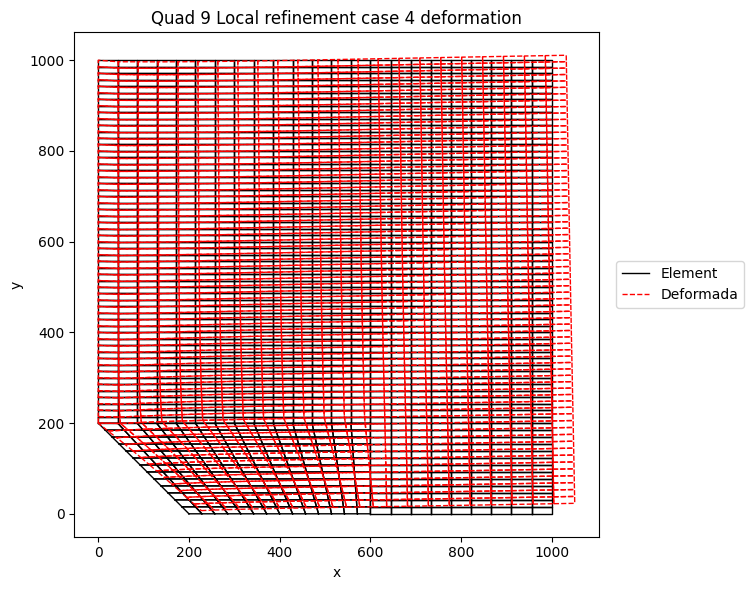

In [310]:
if "BC_1" in grupos:
    nodos_fuerza = grupos["BC_1"]
i=1
apply_distributed_force_especial(grupos, elements, 1500*kN)
u=solve(nodes, elements)
plot_deformed_shape(nodes, elements, u, i, scale=100, folder="Resultados", title=f"{titulo} deformation")
results = compute_stress_strain_components(elements, u)
plot_all_fields(results, nodes, elements, i)
results_inicial= results
for j in nodes:
    j.set_nodalLoad([0,0])
results=0


Ahora con los 3 casos listos, procedemos a ver el tema de la optimización de sección mantiniendo el volumen constante

In [311]:
sigma1_inicial = np.array([res['σ1'] for res in results_inicial])
max_sigma1_inicial = np.max(sigma1_inicial)
print(f"Máximo σ1 inicial: {max_sigma1_inicial:.6f}")

Máximo σ1 inicial: 358.172854


In [312]:
def total_volume(elements):
    return sum(elem.area * elem.section.thickness for elem in elements)
V0 = total_volume(elements)

In [313]:
def total_volume_of_group(elements, group_nodes):
    total_volume = 0.0
    area_total = 0.0
    group_node_ids = set(node.name for node in group_nodes)

    for elem in elements:
        elem_node_ids = set(node.name for node in elem.node_list)
        if elem_node_ids.issubset(group_node_ids):  # ✅ Solo si todos los nodos están en el grupo
            total_volume += elem.area * elem.section.thickness
            area_total += elem.area

    return total_volume, area_total

# --- Volúmenes y áreas ---
# Paso 1: calcular volumen inicial
V_total_inicial = total_volume(elements)

# Paso 2: definir grupos
heads_nodes = grupos['Steel1'] #parte pegada al apoyo
handle_nodes = grupos['Steel2'] #parte externa

# Paso 3: calcular volumen y área de cada grupo
V_heads, A_heads = total_volume_of_group(elements, heads_nodes)
V_handle, A_handle = total_volume_of_group(elements, handle_nodes)

# Paso 4: definir porcentaje de redistribución
reduction_factor = 1.5  # 5% de reducción en manilla

# Paso 5: calcular nuevos espesores
new_thickness_handle = (V_handle * reduction_factor) / A_handle
V_handle_nuevo = new_thickness_handle * A_handle
V_heads_nuevo = V_total_inicial - V_handle_nuevo
new_thickness_heads = V_heads_nuevo / A_heads

# Paso 6: aplicar nuevos espesores
# Primero a manilla
handle_node_ids = set(node.name for node in handle_nodes)
for elem in elements:
    elem_node_ids = set(node.name for node in elem.node_list)
    if elem_node_ids.issubset(handle_node_ids):
        elem.section.thickness = new_thickness_handle

# Luego a heads
heads_node_ids = set(node.name for node in heads_nodes)
for elem in elements:
    elem_node_ids = set(node.name for node in elem.node_list)
    if elem_node_ids.issubset(heads_node_ids):
        elem.section.thickness = new_thickness_heads

# Paso 7: chequear volumen
V_total_final = total_volume(elements)
print("Volumen inicial:", V_total_inicial)
print("Volumen final:", V_total_final)
print("Diferencia relativa:", abs(V_total_final - V_total_inicial) / V_total_inicial)



Volumen inicial: 9784615.384615378
Volumen final: 9784615.384615494
Diferencia relativa: 1.1802609986479186e-14


In [ ]:

print("Volumen total inicial:", V0)
print("Veo que los elementos de la sección pegada a los apoyos tengan el nuevo espesor:", elements[44].section.thickness)
print("Volumen total después de la unificación:", total_volume(elements))
i=2
apply_distributed_force_especial(grupos, elements, 1500*kN)
u=solve(nodes, elements)
plot_deformed_shape(nodes, elements, u, i, scale=5, folder="Resultados")
results = compute_stress_strain_components(elements, u)
plot_all_fields(results, nodes, elements, i)
print(results_inicial)
print(results)




Volumen total inicial: 9784615.384615378
Veo que los elementos de la sección pegada a los apoyos tengan el nuevo espesor: 13.085106382979099
Volumen total después de la unificación: 9784615.384615494


TypeError: 'int' object is not iterable

In [ ]:
sigma1_inicial = np.array([res['σ1'] for res in results_inicial])
sigma1_actual = np.array([res['σ1'] for res in results])
# Diferencia absoluta
max_sigma1_inicial = np.max(sigma1_inicial)
max_sigma1_actual = np.max(sigma1_actual)

# Comparación
print(f"Máximo σ1 inicial: {max_sigma1_inicial:.6f}")
print(f"Máximo σ1 actual:  {max_sigma1_actual:.6f}")

if max_sigma1_actual > max_sigma1_inicial:
    print("🔺 El máximo σ1 AUMENTÓ")
elif max_sigma1_actual < max_sigma1_inicial:
    print("🔻 El máximo σ1 DISMINUYÓ")
else:
    print("⚪ El máximo σ1 NO CAMBIÓ")

Máximo σ1 inicial: 637.274169
Máximo σ1 actual:  478.381286
🔻 El máximo σ1 DISMINUYÓ


In [ ]:
for elem in elements:
    print(f"Elemento {elem.element_tag} - Espesor: {elem.section.thickness} mm")

Elemento 1 - Espesor: 13.076923076923123 mm
Elemento 2 - Espesor: 13.076923076923123 mm
Elemento 3 - Espesor: 13.076923076923123 mm
Elemento 4 - Espesor: 13.076923076923123 mm
Elemento 5 - Espesor: 13.076923076923123 mm
Elemento 6 - Espesor: 13.076923076923123 mm
Elemento 7 - Espesor: 13.076923076923123 mm
Elemento 8 - Espesor: 13.076923076923123 mm
Elemento 9 - Espesor: 13.076923076923123 mm
Elemento 10 - Espesor: 13.076923076923123 mm
Elemento 11 - Espesor: 13.076923076923123 mm
Elemento 12 - Espesor: 13.076923076923123 mm
Elemento 13 - Espesor: 13.076923076923123 mm
Elemento 14 - Espesor: 13.076923076923123 mm
Elemento 15 - Espesor: 13.076923076923123 mm
Elemento 16 - Espesor: 13.076923076923123 mm
Elemento 17 - Espesor: 13.076923076923123 mm
Elemento 18 - Espesor: 13.076923076923123 mm
Elemento 19 - Espesor: 13.076923076923123 mm
Elemento 20 - Espesor: 13.076923076923123 mm
Elemento 21 - Espesor: 13.076923076923123 mm
Elemento 22 - Espesor: 13.076923076923123 mm
Elemento 23 - Espes